### Abstract
We consider a starter code for beginner of this dataset. There is a unbalanced distribution of the classes. To overcome this drawback we want to add images by modifying the given images. We use the following geometric transformations:
* vertical flip,
* rotation,
* perspective transformation (zoom).

After that we select randomly images by the same number of images of every class. 

In consideration of the medical fact that there exists a course of disease we use multi-labels instead of single-labels. That means we set

| diagnosis | single-label |multi-label |
|---| ---| ---|
| 0 | 0 | 0 |
| 1 | 1 | 0, 1|
| 2 | 2 | 0, 1, 2|
| 3 | 3 | 0, 1, 2, 3|
| 4 | 4 | 0, 1, 2, 3, 4|

We trained the model by using a pretrained model. 

In [5]:
import numpy as np
import pandas as pd
import random

import os
path_in = "../input/aptos2019-blindness-detection/"
print(os.listdir(path_in))
print(os.listdir('../input/models'))

['sample_submission.csv', 'train_images', 'train.csv', 'test.csv', 'test_images']
['mask_rcnn_coco.h5', 'model_weights_resnet.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'model_weights_vgg16.h5', 'efficientnetb3_notop.h5', 'mobilenet_1_0_224_tf_no_top.h5']


In [6]:
import cv2
import matplotlib.pyplot as plt

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [125]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D
from keras.optimizers import RMSprop,Adam
from keras.applications import VGG19, DenseNet121, InceptionV3
from keras.callbacks import EarlyStopping

### Define some parameters

In [10]:
q_size = 150
img_channel = 3
num_classes = 5

### Read the input csv files

In [11]:
train_data = pd.read_csv(path_in+'train.csv')
test_data = pd.read_csv(path_in+'test.csv')
sub_org = pd.read_csv(path_in+'sample_submission.csv')

### Define some functions

In [12]:
def plot_bar(data):
    """Simple function to plot the distribution of the classes."""
    dict_data = dict(zip(range(0, num_classes), (((data.value_counts()).sort_index())).tolist()))
    names = list(dict_data.keys())
    values = list(dict_data.values())
    plt.bar(names, values)
    plt.grid()
    plt.show()

In [13]:
def read_images(filepath, data, file_list, size):
    """Read and edit the images of a given folder."""
    for file in file_list:
        img = cv2.imread(filepath+file+'.png')
        img = cv2.resize(img, (size, size))
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 10), -4, 128)
        data[file_list.index(file), :, :, :] = img

In [14]:
def add_flip_image(data, file_list):
    """Simple function to flip images by a given list."""
    temp = np.empty((1, data.shape[1], data.shape[2], data.shape[3]), dtype=np.uint8)
    for index in file_list.index:
        img = data[index, :, :, :]
        vertical_img = cv2.flip(img, 1)
        temp[0, :, :, :] = vertical_img
        data = np.concatenate((data, temp), axis=0)
    return data

In [15]:
def add_rot_image(data, file_list):
    """Simple function to rotate images by a given list."""
    degrees = 15
    temp = np.empty((1, data.shape[1], data.shape[2], data.shape[3]), dtype=np.uint8)
    for index in file_list.index:
        img = data[index, :, :, :]
        rows,cols, channel = img.shape
        Matrix = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
        rotate_img = cv2.warpAffine(img, Matrix, (cols, rows))
        temp[0, :, :, :] = rotate_img
        data = np.concatenate((data, temp), axis=0)
    return data

In [16]:
def add_zoom_image(data, file_list):
    """Simple function to zoom in images by a given list."""
    temp = np.empty((1, data.shape[1], data.shape[2], data.shape[3]), dtype=np.uint8)
    for index in file_list.index:
        img = data[index, :, :, :]
        size = img.shape[0]
        pts1 = np.float32([[10,10],[size-10, 10],[10, size-10],[size-10, size-10]])
        pts2 = np.float32([[0, 0],[size-20, 0],[0, size-20],[size-20, size-20]])
        Matrix = cv2.getPerspectiveTransform(pts1, pts2)
        # zoom image
        img_zoom = cv2.warpPerspective(img, Matrix, (size-20, size-20))
        dim = img.shape 
        # resize image
        rows,cols, channel = img.shape
        dim=(rows, cols)
        img_scale = cv2.resize(img_zoom, dim, interpolation = cv2.INTER_AREA)
        temp[0, :, :, :] = img_scale
        data = np.concatenate((data, temp), axis=0)
    return data

In [17]:
def get_multilabel(diagnosis):
    """A function to get multi-label from single-label."""
    return ','.join([str(i) for i in range(diagnosis + 1)])

### Initialize the original train and test data

In [18]:
X_train_org = np.empty((len(train_data), q_size, q_size, img_channel), dtype=np.uint8)
X_test = np.empty((len(test_data), q_size, q_size, img_channel), dtype=np.uint8)

### Read the image data

In [19]:
read_images(path_in+'train_images/', X_train_org, train_data['id_code'].tolist(), q_size)
read_images(path_in+'test_images/', X_test, sub_org['id_code'].tolist(), q_size)

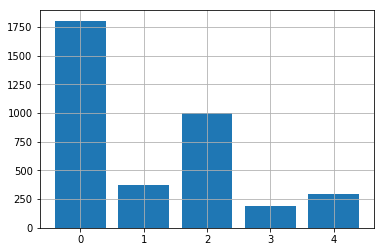

In [20]:
plot_bar(train_data['diagnosis'])

### Add flipped images
Dublicate the images from class 1 to 4 by vertical flip every image.

In [21]:
list_flip = train_data[train_data['diagnosis'] != 0]

In [22]:
X_train_org = add_flip_image(X_train_org, list_flip)
train_data = train_data.append(list_flip, ignore_index=True, sort=False)

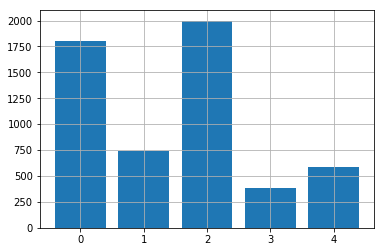

In [23]:
plot_bar(train_data['diagnosis'])

### Add rotated images
Dublicate the images from class 1, 3 and 4 by rotate every image.

In [24]:
list_rot = train_data[(train_data['diagnosis'] != 0)&
                      (train_data['diagnosis'] != 2)]

In [25]:
X_train_org = add_rot_image(X_train_org, list_rot)
train_data = train_data.append(list_rot, ignore_index=True, sort=False)

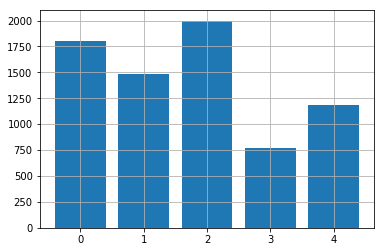

In [26]:
plot_bar(train_data['diagnosis'])

### Add images by zooming
Dublicate the images from class 3 and 4 by zooming every image.

In [27]:
list_zoom = train_data[(train_data['diagnosis'] == 3)|
                       (train_data['diagnosis'] == 4)]

In [28]:
X_train_org = add_zoom_image(X_train_org, list_zoom)
train_data = train_data.append(list_zoom, ignore_index=True, sort=False)

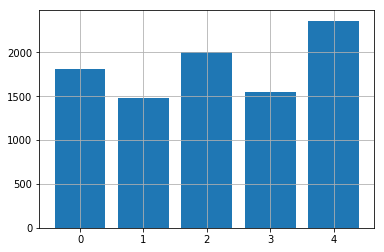

In [29]:
plot_bar(train_data['diagnosis'])

### Select random images for train
The aim is to get equally distributed images for every class.

In [30]:
num_val = (train_data['diagnosis'].value_counts()).min()
list_new = []
for i in range(num_classes):
    temp = random.choices(train_data[train_data['diagnosis']==i].index, k=num_val)
    list_new.extend(temp)
train_data = train_data.loc[list_new]
X_train_org = X_train_org[list_new]

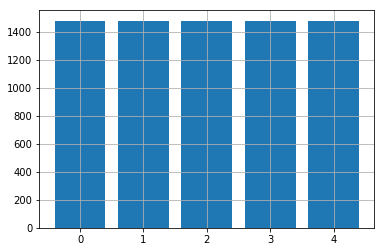

In [31]:
plot_bar(train_data['diagnosis'])

### Plot an image

id_code      3dbfbc11e105
diagnosis               2
Name: 856, dtype: object


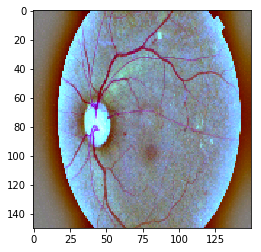

In [32]:
image_number=4019
print(train_data.iloc[image_number])
plt.imshow(X_train_org[image_number], cmap='gray')
plt.show()

### Prepare the labels
Using multi-label instead of single-label.

In [33]:
train_data['multilabel'] = train_data['diagnosis'].apply(get_multilabel)

In [34]:
category =['0','1','2','3','4']
MLB = MultiLabelBinarizer(category)
y_train_org_multi = MLB.fit_transform(train_data['multilabel']).astype('float32')

### Define class weights

In [35]:
class_weight = dict(zip(range(0, num_classes), (((train_data['diagnosis'].value_counts()).sort_index())/len(train_data)).tolist()))

### Convert and scale image data

In [36]:
mean = X_train_org.mean(axis=0)
X_train_org = X_train_org.astype('float32')
X_train_org -= X_train_org.mean(axis=0)
std = X_train_org.std(axis=0)
X_train_org /= X_train_org.std(axis=0)
X_test = X_test.astype('float32')
X_test -= mean
X_test /= std

### Split train and validation data

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_train_org, y_train_org_multi,
                                                  test_size=0.1, random_state=0)

### Create the model

In [40]:
conv_base = VGG19(weights='/kaggle/input/tf-keras-pretrained-model-weights/No Top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  include_top=False,
                  input_shape=(q_size, q_size, img_channel))
conv_base.trainable = True

In [41]:
densenet = DenseNet121(weights='/kaggle/input/tf-keras-pretrained-model-weights/No Top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  include_top=False,
                  input_shape=(q_size, q_size, img_channel))
densenet.trainable = True

In [42]:
inception = InceptionV3(weights='/kaggle/input/tf-keras-pretrained-model-weights/No Top/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  include_top=False,
                  input_shape=(q_size, q_size, img_channel))
inception.trainable = True

In [43]:
model1 = Sequential()
model1.add(conv_base)
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(5, activation='sigmoid'))

In [46]:
model2 = Sequential()
model2.add(densenet)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.5))
model2.add(Dense(5, activation='sigmoid'))

In [47]:
model3 = Sequential()
model3.add(inception)
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.5))
model3.add(Dense(5, activation='sigmoid'))

In [48]:
model1.compile(optimizer = Adam(lr=5e-7),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [49]:
model2.compile(optimizer = Adam(lr=0.0000005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
model3.compile(optimizer = Adam(lr=0.0000005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [51]:
model1.summary()
model2.summary()
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 24,221,765
Trainable params: 24,221,765
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

In [52]:
epochs = 50
batch_size = 32

### Train the model

In [53]:
history1 = model1.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight)

Train on 6660 samples, validate on 740 samples
Epoch 1/50
6660/6660 [==============================] - 51s 8ms/step - loss: 0.1308 - binary_accuracy: 0.6631 - val_loss: 0.4015 - val_binary_accuracy: 0.8141
Epoch 2/50
6660/6660 [==============================] - 33s 5ms/step - loss: 0.0913 - binary_accuracy: 0.7850 - val_loss: 0.3240 - val_binary_accuracy: 0.8641
Epoch 3/50
6660/6660 [==============================] - 33s 5ms/step - loss: 0.0775 - binary_accuracy: 0.8244 - val_loss: 0.2758 - val_binary_accuracy: 0.8792
Epoch 4/50
6660/6660 [==============================] - 33s 5ms/step - loss: 0.0685 - binary_accuracy: 0.8438 - val_loss: 0.2481 - val_binary_accuracy: 0.8916
Epoch 5/50
6660/6660 [==============================] - 33s 5ms/step - loss: 0.0613 - binary_accuracy: 0.8649 - val_loss: 0.2261 - val_binary_accuracy: 0.9005
Epoch 6/50
6660/6660 [==============================] - 33s 5ms/step - loss: 0.0567 - binary_accuracy: 0.8747 - val_loss: 0.2111 - val_binary_accuracy: 0.9089

In [54]:
history2 = model2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight)

Train on 6660 samples, validate on 740 samples
Epoch 1/50
6660/6660 [==============================] - 68s 10ms/step - loss: 0.1690 - acc: 0.5780 - val_loss: 0.6846 - val_acc: 0.6332
Epoch 2/50
6660/6660 [==============================] - 34s 5ms/step - loss: 0.1605 - acc: 0.6005 - val_loss: 0.6440 - val_acc: 0.6573
Epoch 3/50
6660/6660 [==============================] - 34s 5ms/step - loss: 0.1523 - acc: 0.6179 - val_loss: 0.6046 - val_acc: 0.6859
Epoch 4/50
6660/6660 [==============================] - 34s 5ms/step - loss: 0.1458 - acc: 0.6374 - val_loss: 0.5713 - val_acc: 0.7084
Epoch 5/50
6660/6660 [==============================] - 34s 5ms/step - loss: 0.1389 - acc: 0.6519 - val_loss: 0.5425 - val_acc: 0.7295
Epoch 6/50
6660/6660 [==============================] - 34s 5ms/step - loss: 0.1334 - acc: 0.6682 - val_loss: 0.5177 - val_acc: 0.7451
Epoch 7/50
6660/6660 [==============================] - 34s 5ms/step - loss: 0.1276 - acc: 0.6817 - val_loss: 0.4973 - val_acc: 0.7568
Epoch 8

In [55]:
history3 = model3.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight)

Train on 6660 samples, validate on 740 samples
Epoch 1/50
6660/6660 [==============================] - 51s 8ms/step - loss: 0.1312 - acc: 0.6204 - val_loss: 0.5953 - val_acc: 0.6751
Epoch 2/50
6660/6660 [==============================] - 25s 4ms/step - loss: 0.1261 - acc: 0.6423 - val_loss: 0.5715 - val_acc: 0.7065
Epoch 3/50
6660/6660 [==============================] - 25s 4ms/step - loss: 0.1217 - acc: 0.6693 - val_loss: 0.5509 - val_acc: 0.7354
Epoch 4/50
6660/6660 [==============================] - 25s 4ms/step - loss: 0.1176 - acc: 0.6875 - val_loss: 0.5329 - val_acc: 0.7554
Epoch 5/50
6660/6660 [==============================] - 25s 4ms/step - loss: 0.1143 - acc: 0.7032 - val_loss: 0.5135 - val_acc: 0.7773
Epoch 6/50
6660/6660 [==============================] - 25s 4ms/step - loss: 0.1103 - acc: 0.7244 - val_loss: 0.4968 - val_acc: 0.7927
Epoch 7/50
6660/6660 [==============================] - 25s 4ms/step - loss: 0.1065 - acc: 0.7431 - val_loss: 0.4798 - val_acc: 0.8073
Epoch 8/

### Predict on the test images

In [56]:
y_pred_val1 = model1.predict(X_val)
y_pred_val2 = model2.predict(X_val)
y_pred_val3 = model3.predict(X_val)

In [82]:
y_pred_val_classes_ml1 = np.where(y_pred_val1>0.5, 1, 0)
y_pred_val_classes_ml2 = np.where(y_pred_val2>0.5, 1, 0)
y_pred_val_classes_ml3 = np.where(y_pred_val3>0.5, 1, 0)
zipped_ml = np.array([np.hstack((y_pred_val_classes_ml1[i], y_pred_val_classes_ml2[i], y_pred_val_classes_ml3[i])) for i in range(len(y_pred_val_classes_ml1))])
zipped_ml_as_df = pd.DataFrame(zipped_ml)

In [84]:
zipped_ml[0].shape

(15,)

### Create the stacked model

In [123]:
stmodel = Sequential()
stmodel.add(Dense(256, activation='relu', input_shape=(15,)))
stmodel.add(Dense(512, activation='relu'))
stmodel.add(Dense(1024, activation='relu'))
stmodel.add(Dense(2048, activation='relu'))
stmodel.add(Dense(1024, activation='relu'))
stmodel.add(Dense(512, activation='relu'))
stmodel.add(Dense(256, activation='relu'))
stmodel.add(Dense(5, activation='sigmoid'))

In [122]:
del stmodel

In [126]:
callback = EarlyStopping(monitor='acc', mode="max")
stmodel.compile(optimizer = Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [127]:
epochs = 5

In [129]:
history_st = stmodel.fit(zipped_ml, y_val,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[callback],
                    class_weight=class_weight)

Epoch 1/5
740/740 [==============================] - 11s 15ms/step - loss: 0.8903 - acc: 0.9446
Epoch 2/5
740/740 [==============================] - 0s 290us/step - loss: 0.8041 - acc: 0.9716
Epoch 3/5
740/740 [==============================] - 0s 281us/step - loss: 0.7551 - acc: 0.4946


### Write output for submission

In [140]:
st_pred = stmodel.predict(zipped_ml)
st_pred_classes = np.where(st_pred>0.5, 1, 0).sum(axis=1)-1
y_val_classes = np.where(y_val>0.5, 1, 0).sum(axis=1)-1
st_pred_classes

array([1, 2, 0, 0, 1, 2, 0, 0, 1, 1, 2, 2, 0, 0, 3, 3, 0, 2, 3, 1, 3, 2,
       1, 2, 2, 1, 2, 1, 0, 0, 2, 1, 0, 2, 3, 1, 1, 2, 2, 0, 3, 3, 0, 3,
       3, 1, 3, 0, 0, 1, 0, 0, 2, 2, 2, 0, 3, 1, 2, 1, 1, 2, 3, 2, 3, 1,
       1, 2, 2, 3, 3, 1, 0, 1, 3, 1, 2, 0, 3, 3, 2, 0, 2, 2, 1, 3, 3, 3,
       2, 0, 2, 0, 2, 2, 1, 0, 1, 1, 3, 1, 0, 3, 0, 3, 3, 2, 0, 0, 3, 0,
       1, 0, 3, 3, 1, 3, 3, 3, 1, 0, 0, 3, 1, 0, 0, 1, 3, 3, 3, 1, 0, 3,
       3, 0, 0, 0, 2, 2, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 1, 3, 2, 0, 3, 3,
       1, 1, 2, 1, 1, 0, 2, 3, 0, 2, 2, 3, 1, 2, 1, 0, 1, 1, 3, 2, 3, 1,
       1, 2, 2, 2, 1, 1, 0, 0, 3, 2, 3, 2, 0, 2, 3, 3, 3, 1, 3, 0, 2, 1,
       2, 2, 0, 3, 1, 3, 1, 2, 2, 1, 3, 0, 3, 2, 0, 1, 3, 2, 3, 3, 0, 2,
       1, 1, 1, 1, 0, 0, 0, 3, 3, 1, 3, 0, 1, 3, 1, 0, 2, 0, 3, 0, 1, 0,
       3, 0, 2, 1, 3, 2, 0, 0, 3, 1, 0, 2, 3, 2, 3, 2, 3, 3, 0, 1, 0, 3,
       2, 2, 3, 0, 0, 0, 2, 3, 3, 3, 3, 1, 3, 1, 2, 0, 1, 3, 2, 0, 2, 3,
       3, 2, 3, 3, 2, 3, 3, 2, 2, 1, 0, 2, 1, 2, 1,

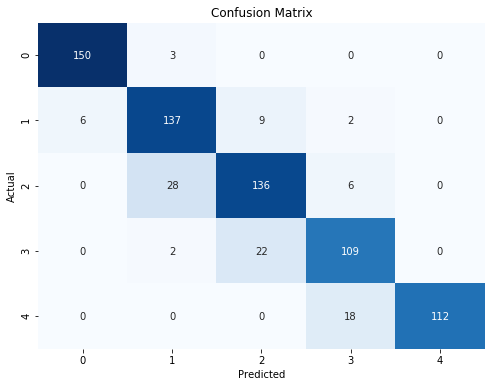

In [142]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val_classes, st_pred_classes)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Visualize the results

#### Confusion matrices for base models

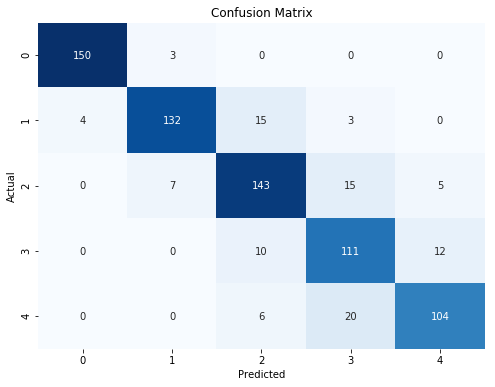

In [143]:
# VGG19
y_pred_val_classes1 = y_pred_val_classes_ml1.sum(axis=1)-1
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val_classes, y_pred_val_classes1)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

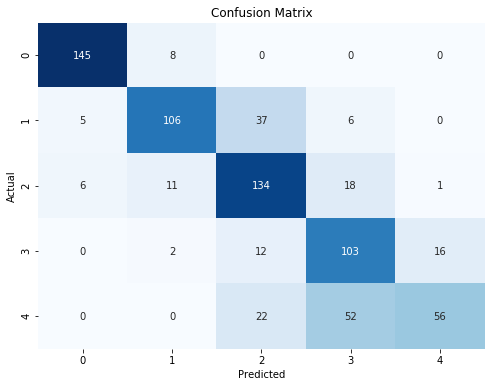

In [144]:
# densenet121
# VGG19
y_pred_val_classes2 = y_pred_val_classes_ml2.sum(axis=1)-1
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val_classes, y_pred_val_classes2)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

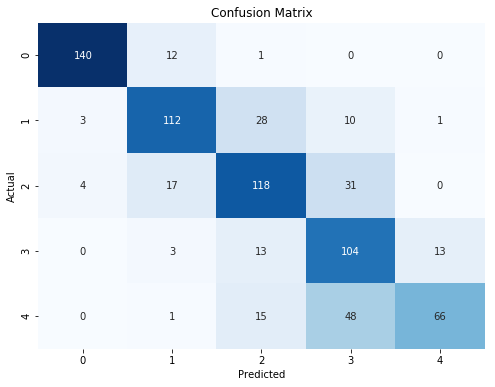

In [145]:
# inceptionV3
y_pred_val_classes3 = y_pred_val_classes_ml3.sum(axis=1)-1
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val_classes, y_pred_val_classes3)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

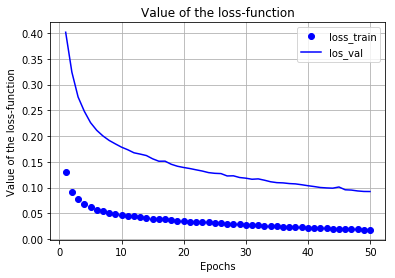

In [146]:
loss = history1.history['loss']
loss_val = history1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='los_val')
plt.title('Value of the loss-function')
plt.xlabel('Epochs')
plt.ylabel('Value of the loss-function')
plt.legend()
plt.grid()
plt.show()

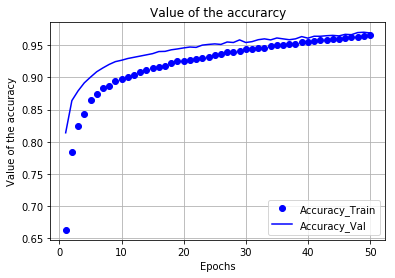

In [147]:
acc = history1.history['binary_accuracy']
acc_val = history1.history['val_binary_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='Accuracy_Train')
plt.plot(epochs, acc_val, 'b', label='Accuracy_Val')
plt.title('Value of the accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Value of the accuracy')
plt.legend()
plt.grid()
plt.show()

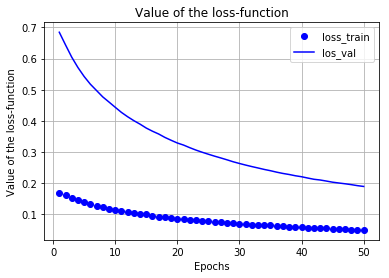

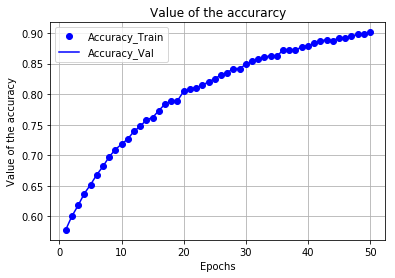

In [150]:
loss = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='los_val')
plt.title('Value of the loss-function')
plt.xlabel('Epochs')
plt.ylabel('Value of the loss-function')
plt.legend()
plt.grid()
plt.show()

acc = history2.history['acc']
acc_val = history2.history['acc']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='Accuracy_Train')
plt.plot(epochs, acc_val, 'b', label='Accuracy_Val')
plt.title('Value of the accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Value of the accuracy')
plt.legend()
plt.grid()
plt.show()

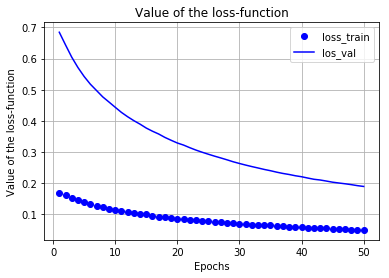

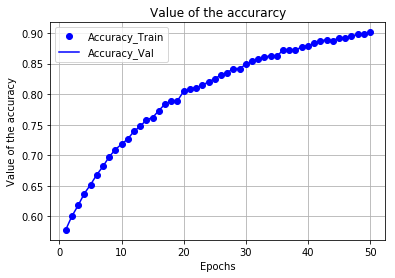

In [151]:
loss = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='los_val')
plt.title('Value of the loss-function')
plt.xlabel('Epochs')
plt.ylabel('Value of the loss-function')
plt.legend()
plt.grid()
plt.show()

acc = history2.history['acc']
acc_val = history2.history['acc']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='Accuracy_Train')
plt.plot(epochs, acc_val, 'b', label='Accuracy_Val')
plt.title('Value of the accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Value of the accuracy')
plt.legend()
plt.grid()
plt.show()